In [3]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


# Libraries


In [1]:
import os
import cv2
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, Dense, Cropping2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from google.colab import drive
from sklearn.model_selection import train_test_split
import segmentation_models as sm
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

Segmentation Models: using `keras` framework.


# Seed

In [4]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = str(42)
np.random.seed(42)
tf.random.set_seed(42)

# Hyperparams

In [5]:
batch_size = 16
lr = 1e-4
backbone = 'resnet34'
epochs = 100
width = 512
height = 384

# Import Data

## Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir('/content/drive/MyDrive/DAP391_G7_Semantic_Classification_for_Urban_Planning_Assessment')
os.listdir()

### Make Files and Folders

In [ ]:
dataset_path = os.path.join('/content/drive/MyDrive/DAP391_G7_Semantic_Classification_for_Urban_Planning_Assessment/Data', 'Final')

files_dir = os.path.join('/content/drive/MyDrive/DAP391_G7_Semantic_Classification_for_Urban_Planning_Assessment/Data','Final')
Unet_file = os.path.join(files_dir, 'Unet.keras')
Linknet_file = os.path.join(files_dir, 'Linknet.keras')
log_Unet_file = os.path.join(files_dir, 'log_Unet.csv')
log_Linknet_file = os.path.join(files_dir, 'log_Linknet.csv')


def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)
create_dir(files_dir)

## Load data

In [ ]:
IMG_DIRS = [
    os.path.join(dataset_path, 'TrainingSet'),
    os.path.join(dataset_path, 'TrainingSet_cutted'),
    os.path.join(dataset_path, 'TrainingSet_flipped'),
    os.path.join(dataset_path, 'TrainingSet_cutted_flipped'),
    ]
MASK_DIRS = [os.path.join(dataset_path, 'SegmentationClass'),
             os.path.join(dataset_path, 'SegmentationClass_cutted'),
             os.path.join(dataset_path, 'SegmentationClass_flipped'),
             os.path.join(dataset_path, 'SegmentationClass_cutted_flipped'),
    ]
def load_image(img_path, mask_path, height, width):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (height, width))
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (height, width))
    mask = (mask > 0).astype(np.uint8)
    return img, mask

def load_images(image_dirs, mask_dirs, height, width):

    images = []
    masks = []

    with ThreadPoolExecutor() as executor:
        for img_dir, mask_dir in zip(image_dirs, mask_dirs):
            image_paths = sorted(glob(os.path.join(img_dir, '*.jpg')))
            mask_paths = sorted(glob(os.path.join(mask_dir, '*.png')))

            results = executor.map(lambda p: load_image(p[0], p[1], height, width), zip(image_paths, mask_paths))
            imgs, masks_tmp = zip(*results)
            images.extend(imgs)
            masks.extend(masks_tmp)

    return np.array(images), np.array(masks)






In [ ]:
train_images, train_masks = load_images(IMG_DIRS, MASK_DIRS, height , width)

In [ ]:
print(train_images.shape)
print(train_masks.shape)

(770, 512, 384, 3)
(770, 512, 384)


## Train/Test

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(616, 512, 384, 3)
(154, 512, 384, 3)
(616, 512, 384)
(154, 512, 384)


# Models make


## Unet

In [ ]:
unet_model = sm.Unet(backbone_name=backbone, encoder_weights='imagenet', classes=1, input_shape=(width, height, 3))
unet_model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
unet_model.summary()

85521592/85521592 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, 512, 384, 3)]        0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, 512, 384, 3)          9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 518, 390, 3)          0         ['bn_data[0][0]']             
 g2D)                                                                                             
                           

## Linknet

In [6]:
linknet_model = sm.Linknet(backbone_name=backbone, encoder_weights='imagenet', classes=1, input_shape=(width, height, 3))
linknet_model.compile(optimizer=Adam(lr), loss='binary_crossentropy', metrics=['accuracy'])
linknet_model.summary()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


AttributeError: module 'keras.api.backend' has no attribute 'int_shape'

## Check points & log

In [ ]:
checkpoint_unet = ModelCheckpoint(Unet_file, verbose=1, save_best_only=True)
checkpoint_linknet = ModelCheckpoint(Linknet_file, verbose=1, save_best_only=True)

csv_logger_unet = CSVLogger(log_Unet_file, separator=',', append=False)
csv_logger_linknet = CSVLogger(log_Linknet_file, separator=',', append=False)


# Model train

## Unet

In [ ]:
unet_history = unet_model.fit(X_train, y_train,
                              steps_per_epoch=len(X_train) // batch_size,
                              epochs=epochs,
                              validation_data=(X_val, y_val),
                              callbacks=[checkpoint_unet, csv_logger_unet])

Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 0.5766 - accuracy: 0.6966
Epoch 1: val_loss improved from inf to 0.56813, saving model to /content/drive/MyDrive/DAP391_G7_Semantic_Classification_for_Urban_Planning_Assessment/Data/Final/Unet.keras
38/38 [==============================] - 136s 2s/step - loss: 0.5766 - accuracy: 0.6966 - val_loss: 0.5681 - val_accuracy: 0.6854
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8887
Epoch 2: val_loss improved from 0.56813 to 0.46125, saving model to /content/drive/MyDrive/DAP391_G7_Semantic_Classification_for_Urban_Planning_Assessment/Data/Final/Unet.keras
38/38 [==============================] - 34s 883ms/step - loss: 0.3652 - accuracy: 0.8887 - val_loss: 0.4613 - val_accuracy: 0.8508
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.2813 - accuracy: 0.9197
Epoch 3: val_loss improved from 0.46125 to 0.40208, saving model to /content/drive/MyDrive/DAP391_G7_Se


Epoch 98: val_loss did not improve from 0.23820
38/38 [==============================] - 13s 337ms/step - loss: 0.0181 - accuracy: 0.9927 - val_loss: 0.3700 - val_accuracy: 0.9226


## Linknet

In [2]:
linknet_history = linknet_model.fit(X_train, y_train,
                                    steps_per_epoch=len(X_train) // batch_size,
                                    epochs=epochs,
                                    validation_data=(X_val, y_val),
                                    callbacks=[checkpoint_linknet, csv_logger_linknet])

NameError: name 'linknet_model' is not defined

# Model Evaluate

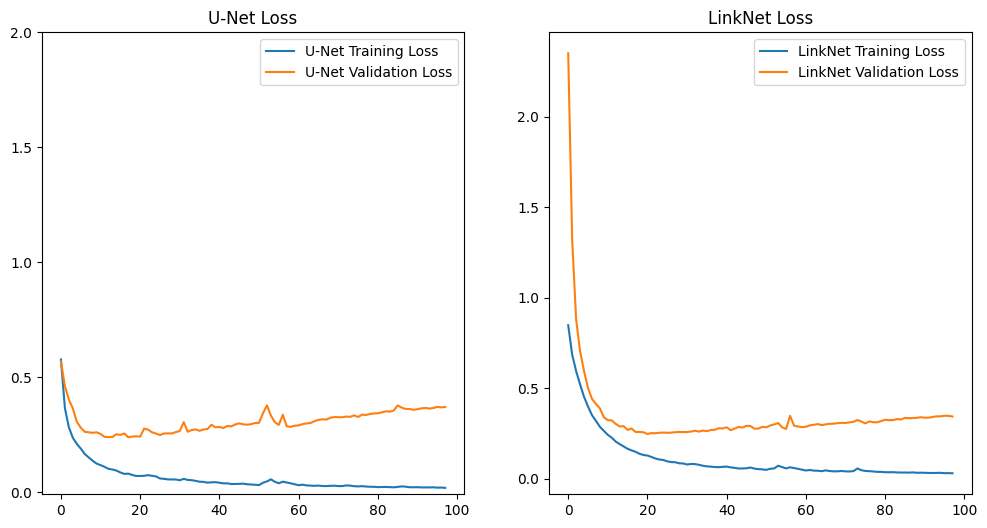

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(unet_history.history['loss'], label='U-Net Training Loss')
plt.plot(unet_history.history['val_loss'], label='U-Net Validation Loss')
plt.yticks([0,0.5,1,1.5,2])
plt.title('U-Net Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(linknet_history.history['loss'], label='LinkNet Training Loss')
plt.plot(linknet_history.history['val_loss'], label='LinkNet Validation Loss')
plt.title('LinkNet Loss')
plt.legend()

plt.show()

In [ ]:
motivation doi tuong